# City Traffic
Congestion Data from https://www.tomtom.com/en_gb/traffic-index/ranking/

City Data from https://www.foursquare.com

In [2]:
%matplotlib inline
from bs4 import BeautifulSoup as bs
import requests
import csv
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import time
import ipywidgets as widgets
from IPython.display import display
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy import stats

## Step 1: Import Data

Data below is written to csv files in order to prevent repeated calls to API.

### Step 1.1 Import Congestion Data
Here, we scrape the tomtom traffic index ranking website, and write the resulting table to a dataframe. The dataframe is passed to a csv file, so it can be reloaded from the csv file if required.

In [17]:
source = requests.get('https://www.tomtom.com/en_gb/traffic-index/ranking/').text #this goes to a website
soup = bs(source, "lxml")

table = soup.find('table', class_='RankingTable__table')
rankings = table.find_all('tr')
# print(rankings[3].prettify())

In [18]:
headers = ['City', 'Country', 'World Rank', 'Congestion Level']
congestion = pd.DataFrame(columns = headers)

for r in rankings[1:]:
    try:
        worldrank = r.find('td', class_='RankingTable__td RankingTable__td--filter-rank').text
        city = r.find('td', class_='RankingTable__td RankingTable__td--city').text
        country = r.find('td', class_='RankingTable__td RankingTable__td--country').text
        congLevel = r.find('div', class_='RankingTable__congestion-value').text
        congestion = congestion.append({'City':city, 'Country':country, 'World Rank':worldrank, 'Congestion Level':congLevel}, ignore_index=True)
    except Exception as e:
        pass
congestion.to_csv('City Congestion Data.csv', index = False)

### Step 1.2: Import City Location Data
Using geolocator, the latitude and longitude of each city is found, and written to the csv file.

In [19]:
geolocator = Nominatim(user_agent="City Traffic",timeout=3)

def cityLatLong(cityCountry):
    try:
        location = geolocator.geocode(cityCountry)
        return(location.latitude, location.longitude)
    except Exception as e:
        return (np.NaN, np.NaN)
    
latlong = congestion[['City', 'Country']].agg(', '.join, axis=1).apply(cityLatLong)
congestion[['Latitude', 'Longitude']] = pd.DataFrame(latlong.values.tolist(), index=latlong.index)

congestion.to_csv('City Congestion Data.csv', index = False)

### Step 1.3: Import Venue Data
Venues are read in for each city in the congestion data. To assemble the responses to all the API calls, we loop through:
* Cities
* Venue Categories
* Pages of results returned by foursquare

The results are written to a csv file. Note: each loop has a delay of 0.6 seconds to accomodate foursquare maximum of 2 API calls per second. Total run time is approx 80 minutes.

In [102]:
client_id = input('What is your Foursquare Client ID')
client_secret = input('What is your Foursquare Client Secret')
version = '20180605' # Foursquare API version

What is your Foursquare Client ID Y1Z2K1T4JITHVIX5DSBZ2C3ULVFWW405BDLE2JTBE1H0HSGL
What is your Foursquare Client Secret VVSA5CRGQ0QLFRHDJHGC1JIMH1CRWPZ0G1MFGNVZ0HJQ4JSM


In [174]:
venue_categories = {'Arts & Entertainment': '4d4b7104d754a06370d81259',
                   'College & University': '4d4b7105d754a06372d81259',
                   'Event': '4d4b7105d754a06373d81259',
                   'Food': '4d4b7105d754a06374d81259',
                   'Nightlife Spot': '4d4b7105d754a06376d81259',
                   'Outdoors & Recreation': '4d4b7105d754a06377d81259',
                   'Professional & Other Places': '4d4b7105d754a06375d81259',
                   'Residence': '4e67e38e036454776db1fb3a',
                   'Shop & Service': '4d4b7105d754a06378d81259',
                   'Travel & Transport': '4d4b7105d754a06379d81259',
                   }

In [175]:
def getNearbyVenues(cities, countries, latitudes, longitudes, csv_file, venue_categories, limit):
    headers = ['API Response Status Code',
              'City', 
              'Country',
              'City Latitude', 
              'City Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category',
              'Venue Sub-Category',
              ]
    offsets = [0, limit]
    
    API_calls = len(offsets) * len(cities) * len(venue_categories)
    
    print(API_calls)
    
    f = widgets.IntProgress(value = 0, min=0, max=API_calls, orientation='horizontal', readout=True, readout_format='d') # instantiate the bar
    display(f) # display the bar
    
    nearby_venues_total = pd.DataFrame(columns = headers)
    nearby_venues_total.to_csv(csv_file, mode='w', index = False, header=True)
    
    # create the API request URL
    endpoint_group = 'venues'
    endpoint = 'explore'
    url = 'https://api.foursquare.com/v2/' + endpoint_group + '/' + endpoint
    
    for city, country, lat, lng in zip(cities, countries, latitudes, longitudes):
        for venue_category, venue_cat_code in venue_categories.items():    
            for offset in offsets:  
                # increment progress bar
                f.value += 1 
                
                # Parameters for the request
                params = dict(
                                client_id=client_id,
                                client_secret=client_secret,
                                v=version,
                                ll= str(lat) + ',' + str(lng),
                                limit=limit,
                                categoryId = venue_cat_code,
                                sortByPopularity=1,
                                offset=offset
                                )
                request = requests.get(url=url, params=params)
                try:    
                    # make the GET request
                    response = request.json()["response"]['groups'][0]['items']

                    # return only relevant information for each nearby venue
                    venues_list = [[
                        request.status_code,
                        city, 
                        country,
                        lat, 
                        lng, 
                        v['venue']['name'], 
                        v['venue']['location']['lat'], 
                        v['venue']['location']['lng'],  
                        venue_category,
                        v['venue']['categories'][0]['name']
                        ] for v in response]
                    
                except Exception as e:
                    venues_list = [[
                        request.status_code,
                        city, 
                        country,
                        lat, 
                        lng, 
                        np.NaN, 
                        np.NaN, 
                        np.NaN,  
                        venue_category,
                        np.NaN
                    ]]
            
                nearby_venues = pd.DataFrame(venues_list, columns = headers)
                nearby_venues_total = nearby_venues_total.append(nearby_venues, ignore_index=True)
                time.sleep(0.51) # to prevent exceeding 2 requests per second
    
    nearby_venues_total.to_csv(csv_file, mode='w', index = False, header=True)
    return(nearby_venues_total)

        

In [176]:
# Commented out only to prevent accidentally running this 1-hr+ process
venues = getNearbyVenues(cities=congestion['City'],
                         countries=congestion['Country'],
                         latitudes=congestion['Latitude'],
                         longitudes=congestion['Longitude'],
                         csv_file = 'Venues Data.csv',
                         venue_categories = venue_categories,
                         limit = 20)

# Test version to get test batch of data
# venues = getNearbyVenues(cities=congestion.loc[:1]['City'],
#                          countries=congestion.loc[:1]['Country'],
#                          latitudes=congestion.loc[:1]['Latitude'],
#                          longitudes=congestion.loc[:1]['Longitude'],
#                          csv_file = 'Test Venues Data.csv',
#                          venue_categories = venue_categories,
#                          limit = 20)

8320


IntProgress(value=0, max=8320)

## Step 2: Process Examine Data

Per above, datasets are all written to csv's to prevent repeated calls to APIs. Dataframes are read from csvs below.

### Step 2.1 Process Congestion Data
Review of data found the following issues, that were cleaned as described below.

In [3]:
congestion = pd.read_csv('City Congestion Data.csv')
congestion.dtypes

City                 object
Country              object
World Rank            int64
Congestion Level     object
Latitude            float64
Longitude           float64
dtype: object

#### Percentages were read as strings. Convert to float.

In [4]:
congestion['Congestion Level'] = congestion['Congestion Level'].str.rstrip('%').astype('float') / 100.0
congestion.dtypes

City                 object
Country              object
World Rank            int64
Congestion Level    float64
Latitude            float64
Longitude           float64
dtype: object

In [5]:
congestion.describe(include='all')

,City,Country,World Rank,Congestion Level,Latitude,Longitude
count,416,416,416.000000,416.000000,415.000000,415.000000
unique,414,57,NaN,NaN,NaN,NaN
top,Hamilton,United States of America,NaN,NaN,NaN,NaN
freq,2,80,NaN,NaN,NaN,NaN
mean,NaN,NaN,208.500000,0.263005,36.979811,2.318555
std,NaN,NaN,120.233107,0.102674,22.438846,67.893732
min,NaN,NaN,1.000000,0.090000,-45.874098,-157.855676
25%,NaN,NaN,104.750000,0.190000,34.719859,-38.501538
50%,NaN,NaN,208.500000,0.250000,43.061936,5.573420
75%,NaN,NaN,312.250000,0.310000,50.835657,23.041161


#### Drop missing Values

In [6]:
congestion.dropna(axis = 0, inplace = True)
congestion[congestion.isnull().any(axis=1)]

,City,Country,World Rank,Congestion Level,Latitude,Longitude


#### Some City names were duplicated (i.e. London, UK and London, Canada). 
This will be considered when processing venue data. Venued data was retrieved using Lat/long coordinates, so cities themselves were not considered duplicates, and were processed as unique cities

In [7]:
congestion[congestion['City'].duplicated(keep = False)]

,City,Country,World Rank,Congestion Level,Latitude,Longitude
44,London,United Kingdom,45,0.38,51.507322,-0.127647
208,Hamilton,New Zealand,209,0.25,-37.787908,175.281807
239,London,Canada,240,0.23,42.983675,-81.249607
311,Hamilton,Canada,312,0.19,43.256080,-79.872858


### Result:

In [8]:
congestion

,City,Country,World Rank,Congestion Level,Latitude,Longitude
0,Bengaluru,India,1,0.71,12.979120,77.591300
1,Manila,Philippines,2,0.71,14.590622,120.979970
2,Bogota,Colombia,3,0.68,4.598080,-74.076044
3,Mumbai,India,4,0.65,18.938771,72.835335
4,Pune,India,5,0.59,18.521428,73.854454
...,...,...,...,...,...,...
411,Dayton,United States of America,412,0.10,39.758948,-84.191607
412,Syracuse,United States of America,413,0.10,43.048122,-76.147424
413,Akron,United States of America,414,0.10,41.083064,-81.518485
414,Cadiz,Spain,415,0.10,36.529744,-6.292898


### Let's visualize these cities

In [9]:
world_lat = 20
world_long = 0

world_map = folium.Map(location=[world_lat, world_long], zoom_start=2, tiles='cartodbpositron')

colors = sns.cubehelix_palette(n_colors = 10, start=2.6, rot=1.1, light = 0.7, hue=1).as_hex()

congestion['Marker Color'] = pd.cut(congestion['Congestion Level'], bins=10, labels=colors)

# add markers to map
for lat, lng, city, country, cong, color in zip(congestion['Latitude'], 
                                                      congestion['Longitude'], 
                                                      congestion['City'], 
                                                      congestion['Country'], 
                                                      congestion['Congestion Level'], 
                                                      congestion['Marker Color']):
    label = '{}, {} \n Congestion: {:.0%}'.format(city, country, cong)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=1,
        parse_html=False).add_to(world_map)  

world_map

### Step 2.2 Process Venues Data

In [10]:
venue_csv_file = 'Venues Data.csv'
venues = pd.read_csv(venue_csv_file)
venues.dtypes

API Response Status Code      int64
City                         object
Country                      object
City Latitude               float64
City Longitude              float64
Venue                        object
Venue Latitude              float64
Venue Longitude             float64
Venue Category               object
Venue Sub-Category           object
dtype: object

### Eliminate data where API call was unsucessful

In [11]:
venues = venues[venues['API Response Status Code'] == 200]
venues.head()

,API Response Status Code,City,Country,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Sub-Category
0,200,Bengaluru,India,12.97912,77.5913,Jawaharlal Nehru Planetarium,12.984570,77.590163,Arts & Entertainment,Planetarium
1,200,Bengaluru,India,12.97912,77.5913,Chitra Kala Parishad,12.989295,77.581115,Arts & Entertainment,Art Gallery
2,200,Bengaluru,India,12.97912,77.5913,Queen Victoria Statue,12.976478,77.599102,Arts & Entertainment,Outdoor Sculpture
3,200,Bengaluru,India,12.97912,77.5913,Visvesvaraya Industrial and Technological Museum,12.974884,77.596526,Arts & Entertainment,Science Museum
4,200,Bengaluru,India,12.97912,77.5913,National Gallery of Modern Arts,12.989790,77.588389,Arts & Entertainment,Art Museum


### Some venues are called "City", drop these

In [12]:
venues = venues[venues['Venue Sub-Category']!='City']
venues.head()

,API Response Status Code,City,Country,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Sub-Category
0,200,Bengaluru,India,12.97912,77.5913,Jawaharlal Nehru Planetarium,12.984570,77.590163,Arts & Entertainment,Planetarium
1,200,Bengaluru,India,12.97912,77.5913,Chitra Kala Parishad,12.989295,77.581115,Arts & Entertainment,Art Gallery
2,200,Bengaluru,India,12.97912,77.5913,Queen Victoria Statue,12.976478,77.599102,Arts & Entertainment,Outdoor Sculpture
3,200,Bengaluru,India,12.97912,77.5913,Visvesvaraya Industrial and Technological Museum,12.974884,77.596526,Arts & Entertainment,Science Museum
4,200,Bengaluru,India,12.97912,77.5913,National Gallery of Modern Arts,12.989790,77.588389,Arts & Entertainment,Art Museum


### Implement one-hot encoding
Add back city *and* country in order to accomodate duplicate cities

In [13]:
venues_onehot = pd.get_dummies(venues[['Venue Sub-Category']], prefix="", prefix_sep="")
venues_onehot = pd.concat([venues[['City', 'Country']], venues_onehot], axis=1, sort=False)
venues_onehot.head()

,City,Country,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,...,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,Bengaluru,India,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bengaluru,India,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bengaluru,India,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bengaluru,India,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bengaluru,India,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Group venues by city

In [14]:
venues_grouped = venues_onehot.groupby(['City', 'Country']).sum()
venues_grouped.head()

,,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
City,Country,,,,,,,,,,,,,,,,,,,,,
A Coruna,Spain,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Aarhus,Denmark,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
Abu Dhabi,United Arab Emirates,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
Adana,Turkey,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adelaide,Australia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Text(0.5, 0, '# Venues')

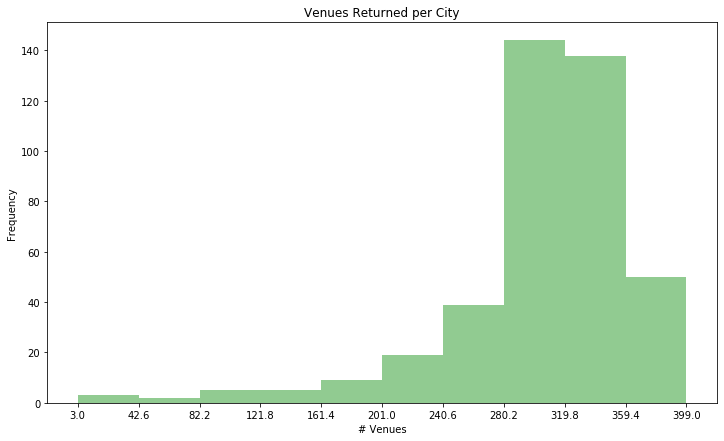

In [30]:
colors = sns.cubehelix_palette(n_colors = 10, start=2.6, rot=1.1, light = 0.7, hue=1).as_hex()

plot_df = venues_grouped.sum(axis=1)
count, bin_edges = np.histogram(plot_df)
plot_df.plot(kind = 'hist', xticks = bin_edges, facecolor = colors[0], alpha = 1, figsize=(12,7))

plt.title('Venues Returned per City')
plt.xlabel('# Venues')

Text(0.5, 0, 'Maximum Number of any Venue Sub-Category')

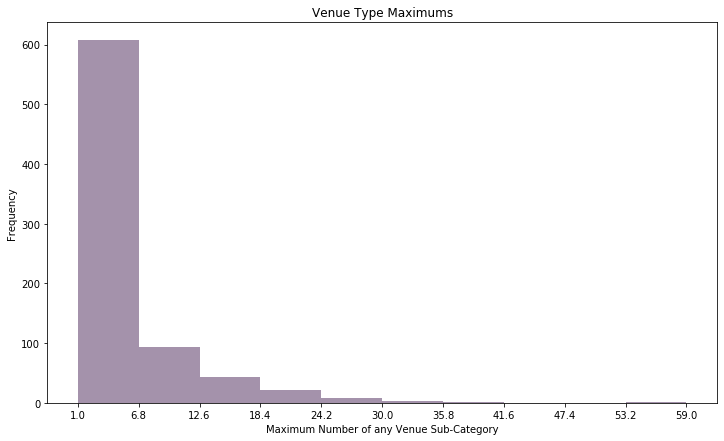

In [31]:
plot_df = venues_grouped.describe(include = 'all').loc['max']
count, bin_edges = np.histogram(plot_df)
plot_df.plot(kind = 'hist', xticks = bin_edges, facecolor = colors[8], alpha = 0.5, figsize=(12,7))

plt.title('Venue Type Maximums')
plt.xlabel('Maximum Number of any Venue Sub-Category')

# Step 3: Clustering using K-Means Algorithm

### Normalize the Venues Dataframe
Normalize across rows by dividing by max value in row

In [17]:
venues_normal = venues_grouped.div(venues_grouped.max(axis=0), axis = 1)
venues_normal.max(axis=0)

ATM                       1.0
Accessories Store         1.0
Acupuncturist             1.0
Adult Boutique            1.0
Adult Education Center    1.0
                         ... 
Yoshoku Restaurant        1.0
Yunnan Restaurant         1.0
Zhejiang Restaurant       1.0
Zoo                       1.0
Zoo Exhibit               1.0
Length: 779, dtype: float64

### Cary out K-Means clustering

In [18]:
# set number of clusters
kclusters = 20

# run k-means clustering
kmeans = KMeans(init = 'k-means++',n_clusters=kclusters, random_state=0).fit(venues_grouped)

# Step 4: Recombine Data & Visualize

In [19]:
venues_grouped_ = venues_grouped.copy()
venues_grouped_.insert(0, 'Cluster Labels', kmeans.labels_)
congestion_ = congestion.copy()
congestion_ = congestion_.set_index(['City', 'Country'])

In [20]:
congestion_combined = pd.concat([venues_grouped_['Cluster Labels'], congestion_], axis=1, sort=False)
congestion_combined.head()

,,Cluster Labels,World Rank,Congestion Level,Latitude,Longitude,Marker Color
City,Country,,,,,,
A Coruna,Spain,10.0,315,0.19,43.371209,-8.395877,#91b66e
Aarhus,Denmark,19.0,261,0.22,56.149628,10.213405,#979c56
Abu Dhabi,United Arab Emirates,0.0,410,0.10,24.474796,54.370576,#91cb91
Adana,Turkey,11.0,181,0.26,37.143800,35.498409,#979c56
Adelaide,Australia,1.0,225,0.24,-34.928180,138.599931,#979c56


In [21]:
congestion_regroup = congestion_combined.groupby('Cluster Labels').mean().reset_index().sort_values(by='Congestion Level', ascending=True).reset_index(drop=True).reset_index()
congestion_regroup = congestion_regroup.rename({'index': 'Cluster Labels Ranked'}, axis=1)
congestion_regroup

,Cluster Labels Ranked,Cluster Labels,World Rank,Congestion Level,Latitude,Longitude
0,0,2.0,337.357143,0.168214,37.383890,-91.212571
1,1,10.0,324.652174,0.179130,40.125483,-3.892726
2,2,8.0,275.888889,0.208889,44.515608,4.142034
3,3,18.0,277.800000,0.210000,4.279298,83.190669
4,4,14.0,272.615385,0.210385,38.246040,-90.864417
5,5,17.0,265.250000,0.217500,50.995446,4.022969
6,6,3.0,253.857143,0.222857,52.687196,10.277583
7,7,16.0,269.200000,0.232500,35.990820,-60.230693
8,8,12.0,213.868421,0.246842,49.067712,8.779348
9,9,1.0,188.351351,0.275135,32.805584,13.152874


In [22]:
ranked_clusters = pd.Series(congestion_regroup['Cluster Labels Ranked'].values,index=congestion_regroup['Cluster Labels']).to_dict()
congestion_plot = congestion_combined.reset_index().copy()
congestion_plot['Cluster Labels Ranked'] = congestion_plot['Cluster Labels'].map(ranked_clusters)

congestion_plot

,City,Country,Cluster Labels,World Rank,Congestion Level,Latitude,Longitude,Marker Color,Cluster Labels Ranked
0,A Coruna,Spain,10.0,315,0.19,43.371209,-8.395877,#91b66e,1.0
1,Aarhus,Denmark,19.0,261,0.22,56.149628,10.213405,#979c56,19.0
2,Abu Dhabi,United Arab Emirates,0.0,410,0.10,24.474796,54.370576,#91cb91,17.0
3,Adana,Turkey,11.0,181,0.26,37.143800,35.498409,#979c56,14.0
4,Adelaide,Australia,1.0,225,0.24,-34.928180,138.599931,#979c56,9.0
...,...,...,...,...,...,...,...,...,...
410,Yekaterinburg,Russia,19.0,35,0.41,56.839104,60.608250,#994c52,19.0
411,Zaragoza,Spain,10.0,391,0.14,41.652134,-0.880943,#91cb91,1.0
412,Zhuhai,China,5.0,39,0.39,22.230520,113.546244,#a1654a,15.0
413,Zurich,Switzerland,12.0,103,0.32,47.372394,8.542333,#9f814a,8.0


### Visualize on Map

In [23]:
world_lat = 20
world_long = 0

world_map = folium.Map(location=[world_lat, world_long], zoom_start=2, tiles='cartodbpositron')

colors = sns.cubehelix_palette(n_colors = kclusters, start=2.6, rot=1.1, light = 0.7, hue=1).as_hex()

congestion_plot['Marker Color'] = pd.cut(congestion_plot['Congestion Level'], bins=kclusters, labels=colors)
congestion_plot['Marker Color (Cluster)'] = pd.cut(congestion_plot['Cluster Labels Ranked'], bins=kclusters, labels=colors)

# add markers to map
for lat, lng, city, country, cong, congcolor, cluster, clustercolor in zip(congestion_plot['Latitude'], 
                                                      congestion_plot['Longitude'], 
                                                      congestion_plot['City'], 
                                                      congestion_plot['Country'], 
                                                      congestion_plot['Congestion Level'], 
                                                      congestion_plot['Marker Color'],
                                                      congestion_plot['Cluster Labels Ranked'],
                                                      congestion_plot['Marker Color (Cluster)']):
    label = '{}, {} \n Congestion: {:.0%} \n Cluster: {:.0f}'.format(city, country, cong, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color=clustercolor,
        fill=True,
        fill_color=clustercolor,
        fill_opacity=1,
        parse_html=False).add_to(world_map)  

world_map

Text(0, 0.5, 'Congestion Level')

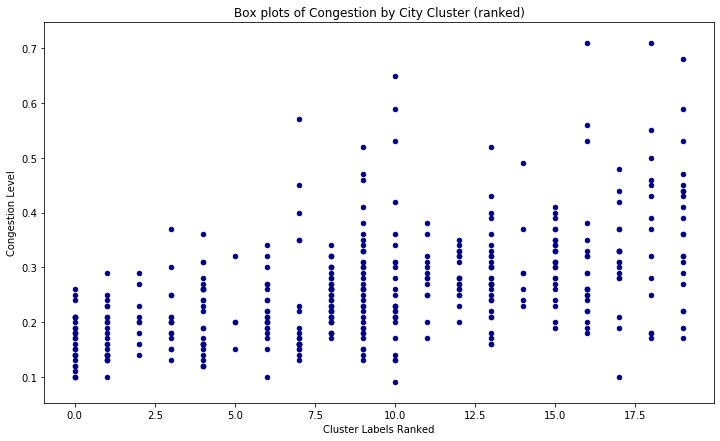

In [32]:
congestion_plot.plot(kind='scatter', x='Cluster Labels Ranked', y='Congestion Level', color='darkblue', figsize=(12,7))
plt.title('Box plots of Congestion by City Cluster (ranked)')
plt.ylabel('Congestion Level')

Text(0, 0.5, 'Congestion Level')

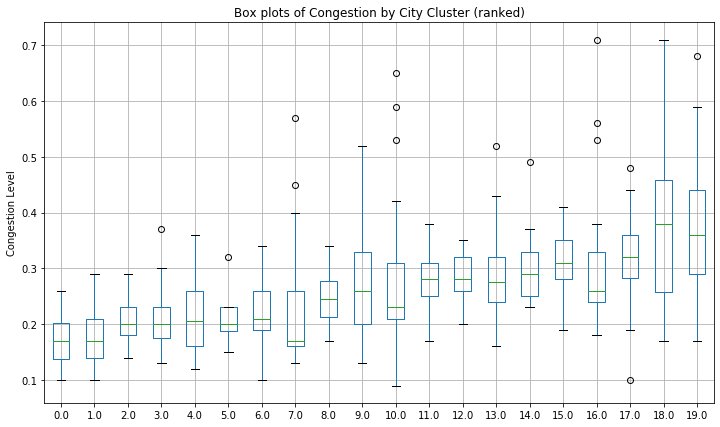

In [33]:
congestion_boxplot = congestion_plot.pivot(columns = 'Cluster Labels Ranked', values = 'Congestion Level')
congestion_boxplot.iloc[:,1:].boxplot(figsize=(12,7))

plt.title('Box plots of Congestion by City Cluster (ranked)')
plt.ylabel('Congestion Level')

Text(0, 0.5, 'Mean Congestion Level')

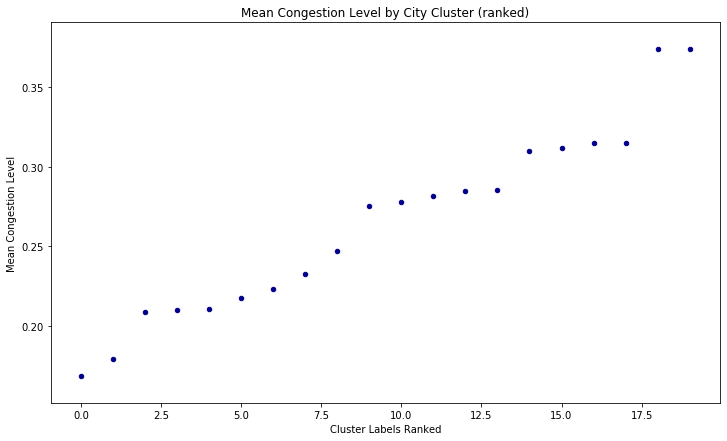

In [34]:
congestion_regroup.plot(kind='scatter', x='Cluster Labels Ranked', y='Congestion Level', color='darkblue', figsize=(12,7))
plt.title('Mean Congestion Level by City Cluster (ranked)')
plt.ylabel('Mean Congestion Level')

In [27]:
congestion_boxplot.describe()

Cluster Labels Ranked,NaN,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
count,1.00,28.000000,23.000000,9.000000,15.000000,26.000000,4.000000,21.000000,20.000000,38.000000,...,26.000000,13.000000,18.000000,30.000000,7.000000,25.000000,21.000000,18.000000,14.000000,21.000000
mean,0.22,0.168214,0.179130,0.208889,0.210000,0.210385,0.217500,0.222857,0.232500,0.246842,...,0.277692,0.281538,0.285000,0.285333,0.310000,0.311600,0.314762,0.315000,0.374286,0.374286
std,NaN,0.045628,0.047855,0.048591,0.062221,0.067793,0.072284,0.056846,0.123198,0.044425,...,0.138139,0.057568,0.041195,0.081526,0.091833,0.058358,0.133702,0.089787,0.156977,0.131171
min,0.22,0.100000,0.100000,0.140000,0.130000,0.120000,0.150000,0.100000,0.130000,0.170000,...,0.090000,0.170000,0.200000,0.160000,0.230000,0.190000,0.180000,0.100000,0.170000,0.170000
25%,0.22,0.137500,0.140000,0.180000,0.175000,0.160000,0.187500,0.190000,0.160000,0.212500,...,0.210000,0.250000,0.260000,0.240000,0.250000,0.280000,0.240000,0.282500,0.257500,0.290000
50%,0.22,0.170000,0.170000,0.200000,0.200000,0.205000,0.200000,0.210000,0.170000,0.245000,...,0.230000,0.280000,0.280000,0.275000,0.290000,0.310000,0.260000,0.320000,0.380000,0.360000
75%,0.22,0.202500,0.210000,0.230000,0.230000,0.260000,0.230000,0.260000,0.260000,0.277500,...,0.310000,0.310000,0.320000,0.320000,0.330000,0.350000,0.330000,0.360000,0.457500,0.440000
max,0.22,0.260000,0.290000,0.290000,0.370000,0.360000,0.320000,0.340000,0.570000,0.340000,...,0.650000,0.380000,0.350000,0.520000,0.490000,0.410000,0.710000,0.480000,0.710000,0.680000


# Step 5: Significance
Have we found a significant relationship? I'm not going to do a detailed statistical analysis, just check whether the mean of the group with least congestion is significantly different from the group with most congestion. The Student's T can be estimated using the following formula:

$$t=\frac{\bar{x}_{1} - \bar{x}_{2}}{\left( \frac{s_{1}^{2}}{n_{1}} + \frac{s_{2}^{2}}{n_{2}}\right)^{\frac{1}{2}}}$$

With:

$$Degrees of Freedom =\frac{\left( \frac{s_{1}^{2}}{n_{1}} + \frac{s_{2}^{2}}{n_{2}}\right)^{2}}  {\frac{\left(\frac{s_{1}^{2}}{n_{1}} \right)^{2} }{n_{1}} +\frac{\left(\frac{s_{2}^{2}}{n_{2}} \right)^{2} }{n_{2}}}$$

Where:

t - Student's t

$\bar{x}_{1}$ - Average of Sample 1

$\bar{x}_{2}$ - Average of Sample 2

$s_{1}$ - Standard Deviation of Sample 1

$s_{2}$ - Standard Deviation of Sample 2

$n_{1}$ - Number of Observations in Sample 1

$n_{2}$ - Number of Observations in Sample 2

In [28]:
x1 = congestion_boxplot.describe().loc['mean'].iloc[1]
x2 = congestion_boxplot.describe().loc['mean'].iloc[-1]
s1 = congestion_boxplot.describe().loc['std'].iloc[1]
s2 = congestion_boxplot.describe().loc['std'].iloc[-1]
n1 = congestion_boxplot.describe().loc['count'].iloc[1]
n2 = congestion_boxplot.describe().loc['count'].iloc[-1]
print(x1, x2, s1, s2, n1, n2)

0.1682142857142857 0.3742857142857143 0.045627604658565045 0.1311705541869603 28.0 21.0


In [29]:
t = (x1 - x2) / ((s1**2 / n1) + (s2**2 / n2))**0.5
dof = ((s1**2 / n1) + (s2**2 / n2))**2 / ((s1**2 / n1)**2 / n1 + (s2**2 / n2)**2 / n2)
p = 1 - stats.t.cdf(t,df=dof)
if p >= 0.95:
    print("Cluster with lowest congestion level is significantly different from cluster with highest congestion level, with p = ", p)
elif p < 0.95:
    print("Cluster with lowest congestion level is not significantly different from cluster with highest congestion level, with p = ", p)

Cluster with lowest congestion level is significantly different from cluster with highest congestion level, with p =  0.9999998355667477
